# Full fit setup
## _Create full fit design matrix and configuration file_

This notebook creates a design matrix and python configuration file for the fitting of the full 128-point data.

For a guide on how and why these steps are done see `first_level_fit_low_res_demo.ipynb`.

For the actual fitting script run `first_level_fit.py`.

## 1. Design matrix

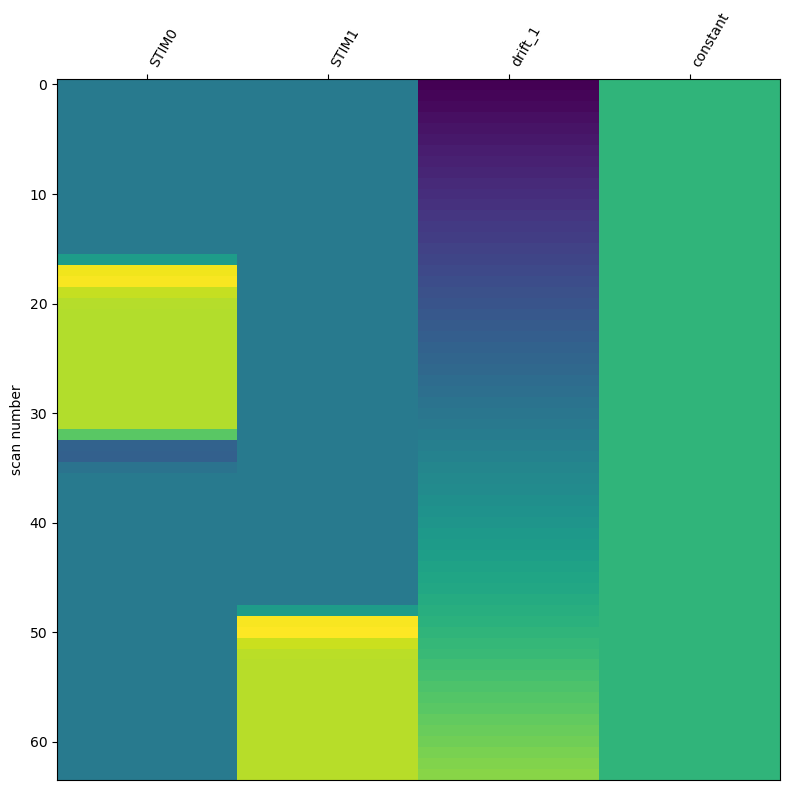

In [1]:
# We use the nilearn package + numpy + pandas to make the design matrix
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculations to create the design matrix
tr          = 4.0  # repetition time in seconds
n_blocks    = 2  # Number of stimulation blocks
n_scans     = 64  # Total number of scan points (128)
frame_times = np.arange(n_scans) * tr  # Time point of each data point
conditions  = [f'STIM{i}' for i in range(n_blocks)] # each trial gets its own regressor
duration    = [16.*tr,] * n_blocks # Duration of each stimulation block
onsets = [tr*15.+tr*32.*k for k in np.arange(0, n_blocks)] # Start time of each stimulation block.
events = pd.DataFrame({'trial_type': conditions, 
                       'onset'     : onsets,
                       'duration'  : duration})

# Pass to nilearn function to create design matrix
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    drift_model='polynomial',
    drift_order=1, 
    hrf_model='glover') 

# Plot the designmatrix for inspection
fig = plt.figure(figsize=(8,8))
_ = plot_design_matrix(design_matrix, ax=fig.gca())

design_matrix.to_csv('designmat.csv', index=False, header=False)


## 2. Configuration file

In [2]:
%%writefile fmrs_model.py
from numpy import dot

# Parameter - functional relationships
Parameters = {
    'conc'     : {'dynamic': 'model_glm', 'params': [f'beta{i}' for i in range(4)]},
    'gamma'    : 'fixed',
    'sigma'    : {'dynamic': 'model_glm', 'params': [f'beta{i}' for i in range(4)]},
    'eps'      : 'fixed',
    'baseline' : 'fixed',
    'Phi_0'    : 'fixed',
    'Phi_1'    : 'fixed'}

# Bounds on free fitted parameters
Bounds = {
    'gamma': (0, None),
    'beta3': (0, None)}


# Dynamic models
def model_glm(p, t):
    return dot(t, p)


# Dynamic model gradients
def model_glm_grad(p, t):
    return t.T


Overwriting fmrs_model.py
